## OPTUNA MLP optimization 

In [1]:
"""
Optuna example that optimizes a Keras model
"""
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
 

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState


print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')
print("Not using GPU !!!")    

seed = 175
nb_classes = 10
NTRIALS = 100
MTR='val_categorical_accuracy'
NEPOCHS = 100
BSIZES = [32,64,128]  # batch size for Optuna search
#BSIZES = [16,32,64]  # batch size for Optuna search
MINLR = 0.0001
MAXLR = 0.0005
MAXNL = 4 # maximum number of layer for Optuna search
MINNEU = 8 # minimum number of neurons per layer for Optuna search
MAXNEU = 96   # maximum number of neurons per layer for Optuna search
PATIEN = 20 # maximum pacience for early stop and checkpoint
REGL1 = 0.0001
outdir = "./optuna"


# OPTUNA trial syntax
# filters=trial.suggest_categorical("filters", [32, 64]),
# activation=trial.suggest_categorical("activation", ["relu", "linear"]),
# learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
# num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)       

TensorFlow 2.8.0
Number of available GPUs : 1
Not using GPU !!!


/Users/sznajder/WorkM1/miniforge3/envs/tf28/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load MNIST Dataset

In [2]:
# Load MNIST dataset (28x28 pixel images)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("y_train=",y_train)
Y_train= utils.to_categorical(y_train, nb_classes)
print("Y_Train=",Y_train)
Y_test = utils.to_categorical(y_test, nb_classes)


y_train= [5 0 4 ... 5 6 8]
Y_Train= [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## Define Functions : Optuna objetive and model constrution

In [3]:
# Optuna objective function
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    # early stopping callback
    es = EarlyStopping(monitor=MTR, patience=PATIEN)

    # Learning rate scheduler 
    ls = ReduceLROnPlateau(monitor=MTR, factor=0.8, patience=PATIEN, min_lr=0.00001)


    # model checkpoint callback to save best model architecture + parameters into bestmodel.h5
    chkp = ModelCheckpoint('bestmodel.h5', monitor=MTR, verbose=0, save_best_only=True, mode='auto', save_freq='epoch')

    # Optuna pruner callback to drop non promising trials 
    # BE CAREFULL as this might bias towards faster learning models with lower performance at the end of traing !!!
    pru = optuna.integration.TFKerasPruningCallback(trial, monitor=MTR)


    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(X_train, Y_train, 
              batch_size= trial.suggest_categorical("bsize", BSIZES),  
              epochs=NEPOCHS, 
              verbose=0,
              validation_split=0.2,
              callbacks=[es,ls,chkp],
              shuffle=True,
              )

    
    # Load the best saved model
    model = tf.keras.models.load_model( 'bestmodel.h5',)
    

    # Plot Loss and Accuracy versus Epoch
    
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # Plot training accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    #ax.plot(history.history['accuracy'], label='accuracy')
    #ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Display plots
    fig = plt.gcf()
    plt.show()
#    fig.savefig(fname+'.pdf')
        
    Y_pred = model.predict(X_test)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(Y_test, Y_pred)
    return accuracy.result().numpy()   
    
# Model constrution
def create_model(trial):
    model = Sequential()

    # Define the MLP.
    nlayers = trial.suggest_int("nlayers", 1, MAXNL)
    model = Sequential()
    model.add(Input(shape=(784)))   # Flattened input shape
    for i in range(nlayers):
        nhidden = trial.suggest_int("nhidden_l{}".format(i), MINNEU, MAXNEU, log=True)
        model.add( Dense(nhidden, name=f'dense_{i}' ,activation="relu" , kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )
    model.add( Dense(nb_classes, name=f'dense_out'  , activation="softmax", kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )

    
    # Define the optimizer
    optim = Adam( learning_rate= trial.suggest_float("learning_rate", MINLR, MAXLR, log=True) )

# compile the model
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    model.summary(expand_nested=True)
    return model
    


[I 2024-02-27 13:45:43,452] Using an existing study with name 'mlp_study' instead of creating a new one.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 44)                34540     
                                                                 
 dense_out (Dense)           (None, 10)                450       
                                                                 
Total params: 34,990
Trainable params: 34,990
Non-trainable params: 0
_________________________________________________________________


2024-02-27 13:45:43.589548: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


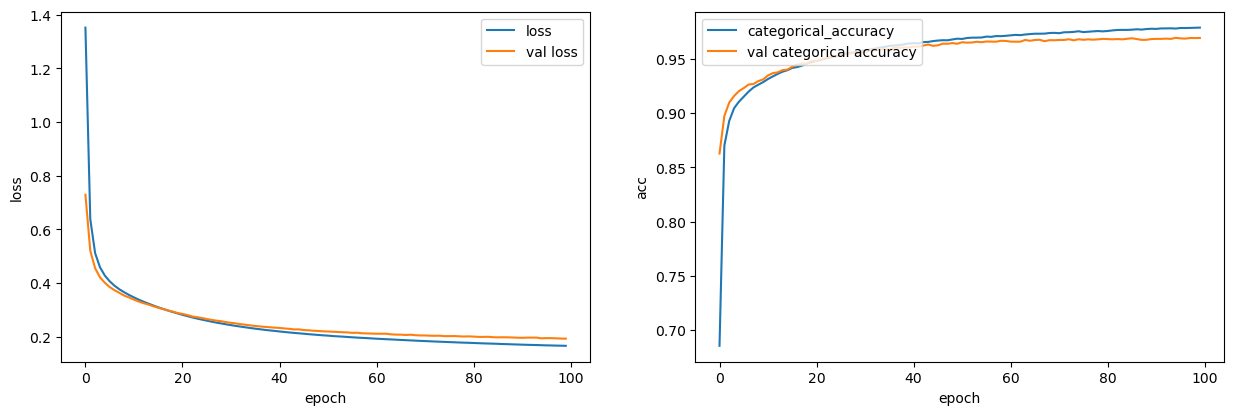

[I 2024-02-27 13:46:06,515] Trial 2 finished with value: 0.9693999886512756 and parameters: {'nlayers': 1, 'nhidden_l0': 44, 'learning_rate': 0.00015440196746668633, 'bsize': 128}. Best is trial 2 with value: 0.9693999886512756.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 25)                19625     
                                                                 
 dense_out (Dense)           (None, 10)                260       
                                                                 
Total params: 19,885
Trainable params: 19,885
Non-trainable params: 0
_________________________________________________________________


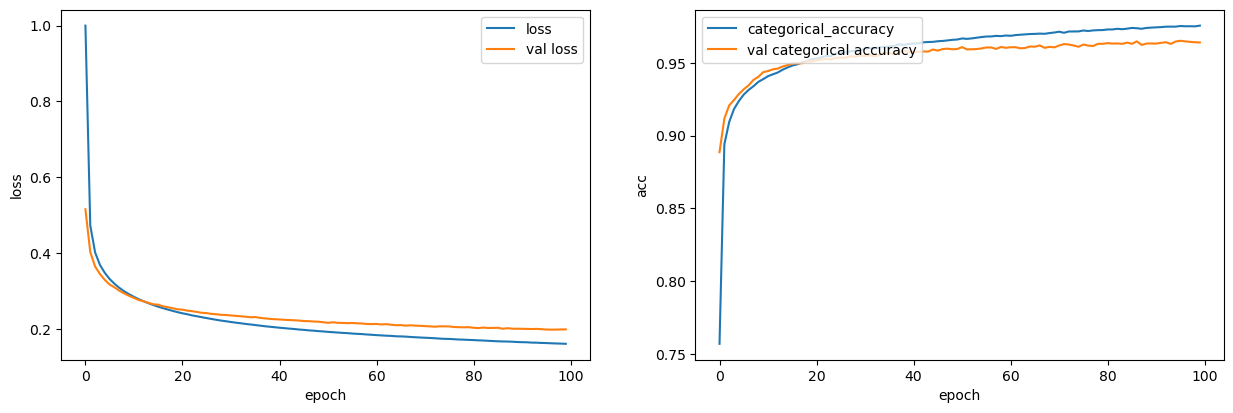

[I 2024-02-27 13:47:06,964] Trial 3 finished with value: 0.9628999829292297 and parameters: {'nlayers': 1, 'nhidden_l0': 25, 'learning_rate': 0.00014405233163411815, 'bsize': 32}. Best is trial 2 with value: 0.9693999886512756.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 74)                58090     
                                                                 
 dense_out (Dense)           (None, 10)                750       
                                                                 
Total params: 58,840
Trainable params: 58,840
Non-trainable params: 0
_________________________________________________________________


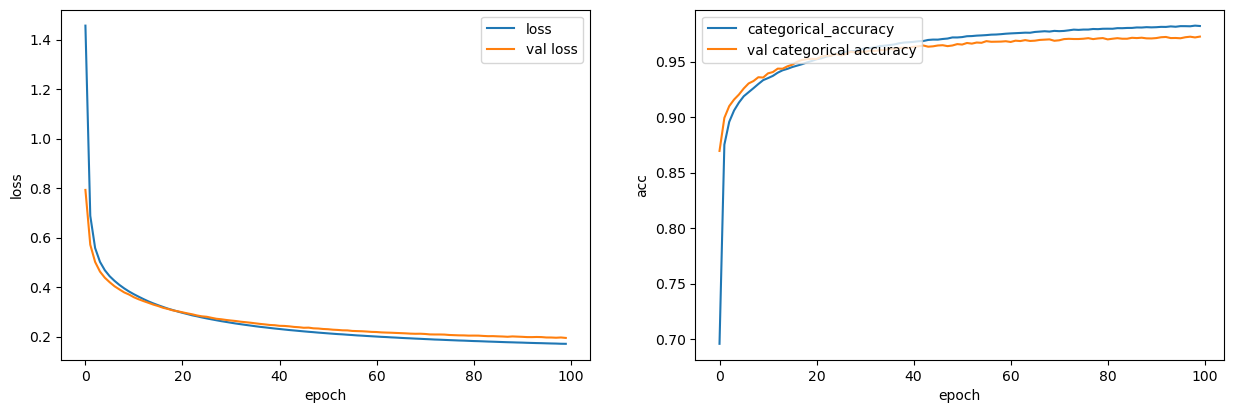

[I 2024-02-27 13:47:36,084] Trial 4 finished with value: 0.974399983882904 and parameters: {'nlayers': 1, 'nhidden_l0': 74, 'learning_rate': 0.00011338482562865309, 'bsize': 128}. Best is trial 4 with value: 0.974399983882904.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 86)                67510     
                                                                 
 dense_1 (Dense)             (None, 67)                5829      
                                                                 
 dense_2 (Dense)             (None, 60)                4080      
                                                                 
 dense_out (Dense)           (None, 10)                610       
                                                                 
Total params: 78,029
Trainable params: 78,029
Non-trainable params: 0
_________________________________________________________________


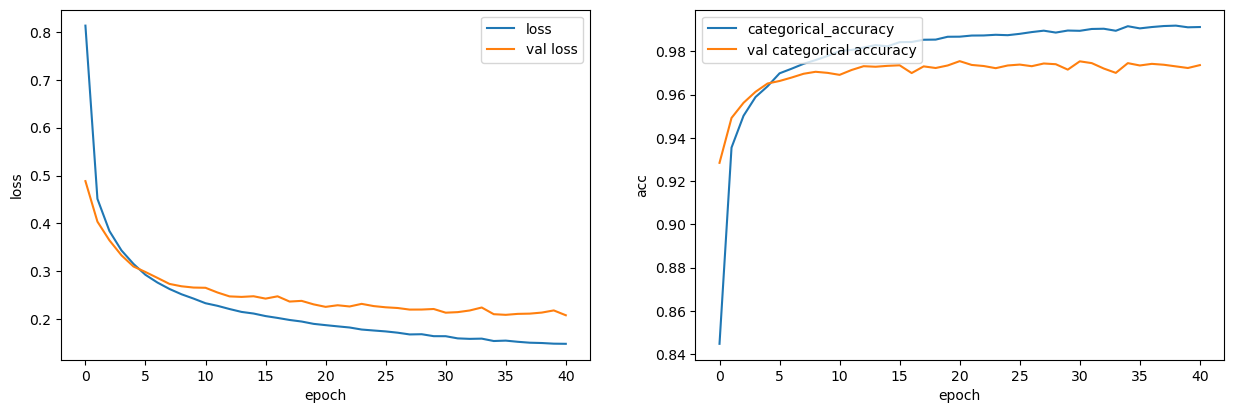

[I 2024-02-27 13:48:02,253] Trial 5 finished with value: 0.9761999845504761 and parameters: {'nlayers': 3, 'nhidden_l0': 86, 'nhidden_l1': 67, 'nhidden_l2': 60, 'learning_rate': 0.00032087823018588676, 'bsize': 64}. Best is trial 5 with value: 0.9761999845504761.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 42)                32970     
                                                                 
 dense_out (Dense)           (None, 10)                430       
                                                                 
Total params: 33,400
Trainable params: 33,400
Non-trainable params: 0
_________________________________________________________________


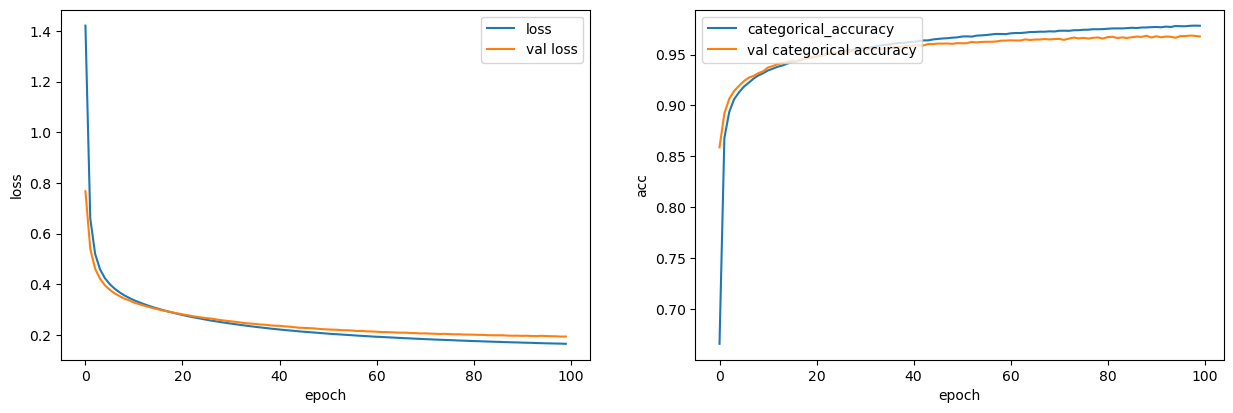

[I 2024-02-27 13:48:26,389] Trial 6 finished with value: 0.9700000286102295 and parameters: {'nlayers': 1, 'nhidden_l0': 42, 'learning_rate': 0.00014611196052649432, 'bsize': 128}. Best is trial 5 with value: 0.9761999845504761.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 28)                21980     
                                                                 
 dense_1 (Dense)             (None, 48)                1392      
                                                                 
 dense_2 (Dense)             (None, 11)                539       
                                                                 
 dense_out (Dense)           (None, 10)                120       
                                                                 
Total params: 24,031
Trainable params: 24,031
Non-trainable params: 0
_________________________________________________________________


[W 2024-02-27 13:48:54,229] Trial 7 failed with parameters: {'nlayers': 3, 'nhidden_l0': 28, 'nhidden_l1': 48, 'nhidden_l2': 11, 'learning_rate': 0.00024127726825528417, 'bsize': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/sznajder/WorkM1/miniforge3/envs/tf28/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/4k/3rlblhv55d10vc6y4lnyb0v40000gn/T/ipykernel_33308/828105472.py", line 25, in objective
    history = model.fit(X_train, Y_train,
  File "/Users/sznajder/WorkM1/miniforge3/envs/tf28/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/Users/sznajder/WorkM1/miniforge3/envs/tf28/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "/Users/sznajder/WorkM1/miniforge3/envs/tf28/lib/python3.8/site-

KeyboardInterrupt: 

In [4]:
  # Set Optuna
study = optuna.create_study(
        study_name="mlp_study",
        sampler=optuna.samplers.TPESampler(),
        direction="maximize",
        storage="sqlite:///optuna_mlp_mnist.db",
        load_if_exists=True,
    )


# Optimize
study.optimize(objective, n_trials=NTRIALS, gc_after_trial=True)

## Print Optuna Results

In [ ]:

# Results

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



#trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#trials = study.get_trials(deepcopy=False)
#print("Study statistics: ")
#print("  Number of finished trials: ", len(study.trials))
#print("  Number of trials: ", len(trials))

    
# reload study and continue optimizing
#study = optuna.load_study(study_name="example-study", storage="sqlite:///example.db")
#study.optimize(objective, n_trials=30)    

